In [42]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [122]:
%matplotlib inline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
!pwd

/Users/abhijithroy/Public/Projects/H1N1andSeasonalV


In [3]:
os.listdir('./')

['training_set_labels.csv',
 'H1N1predictor.ipynb',
 'submission_format.csv',
 'training_set_features.csv',
 '.ipynb_checkpoints',
 'test_set_features.csv']

In [4]:
# loading the dataset, train and test
train_data = pd.read_csv('training_set_features.csv')
test_data = pd.read_csv('test_set_features.csv')
features_df = pd.read_csv('training_set_labels.csv')
sample_submission = pd.read_csv('submission_format.csv')

In [30]:
print("\nTrain data columns : ")
print(train_data.columns)
print("\nTest Data columns : ")
print(test_data.columns)
print("\nLabels Set columns : ")
print(features_df.columns)
print("\Sample Submission columns : ")
print(sample_submission.columns)



Train data columns : 
Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation'],
      dtype='object')

Test Data columns : 
Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavior

In [10]:
features_df

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,0,0,0
1,1,0,1
2,2,0,0
3,3,0,1
4,4,0,0
...,...,...,...
26702,26702,0,0
26703,26703,0,0
26704,26704,0,1
26705,26705,0,0


In [9]:
sample_submission.head()

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,26707,0.5,0.7
1,26708,0.5,0.7
2,26709,0.5,0.7
3,26710,0.5,0.7
4,26711,0.5,0.7


In [18]:
for item, val in train_data.dtypes.items():
    if val != 'object':
        print(val)

int64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64


In [19]:
numeric_columns = [col for col, col_type in train_data.dtypes.items() if col_type != "object"]
non_numeric_columns = [col for col, col_type in train_data.dtypes.items() if col_type == "object"]

In [21]:
print(numeric_columns)
print(non_numeric_columns)

['respondent_id', 'h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds', 'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands', 'behavioral_large_gatherings', 'behavioral_outside_home', 'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal', 'chronic_med_condition', 'child_under_6_months', 'health_worker', 'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'household_adults', 'household_children']
['age_group', 'education', 'race', 'sex', 'income_poverty', 'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa', 'employment_industry', 'employment_occupation']


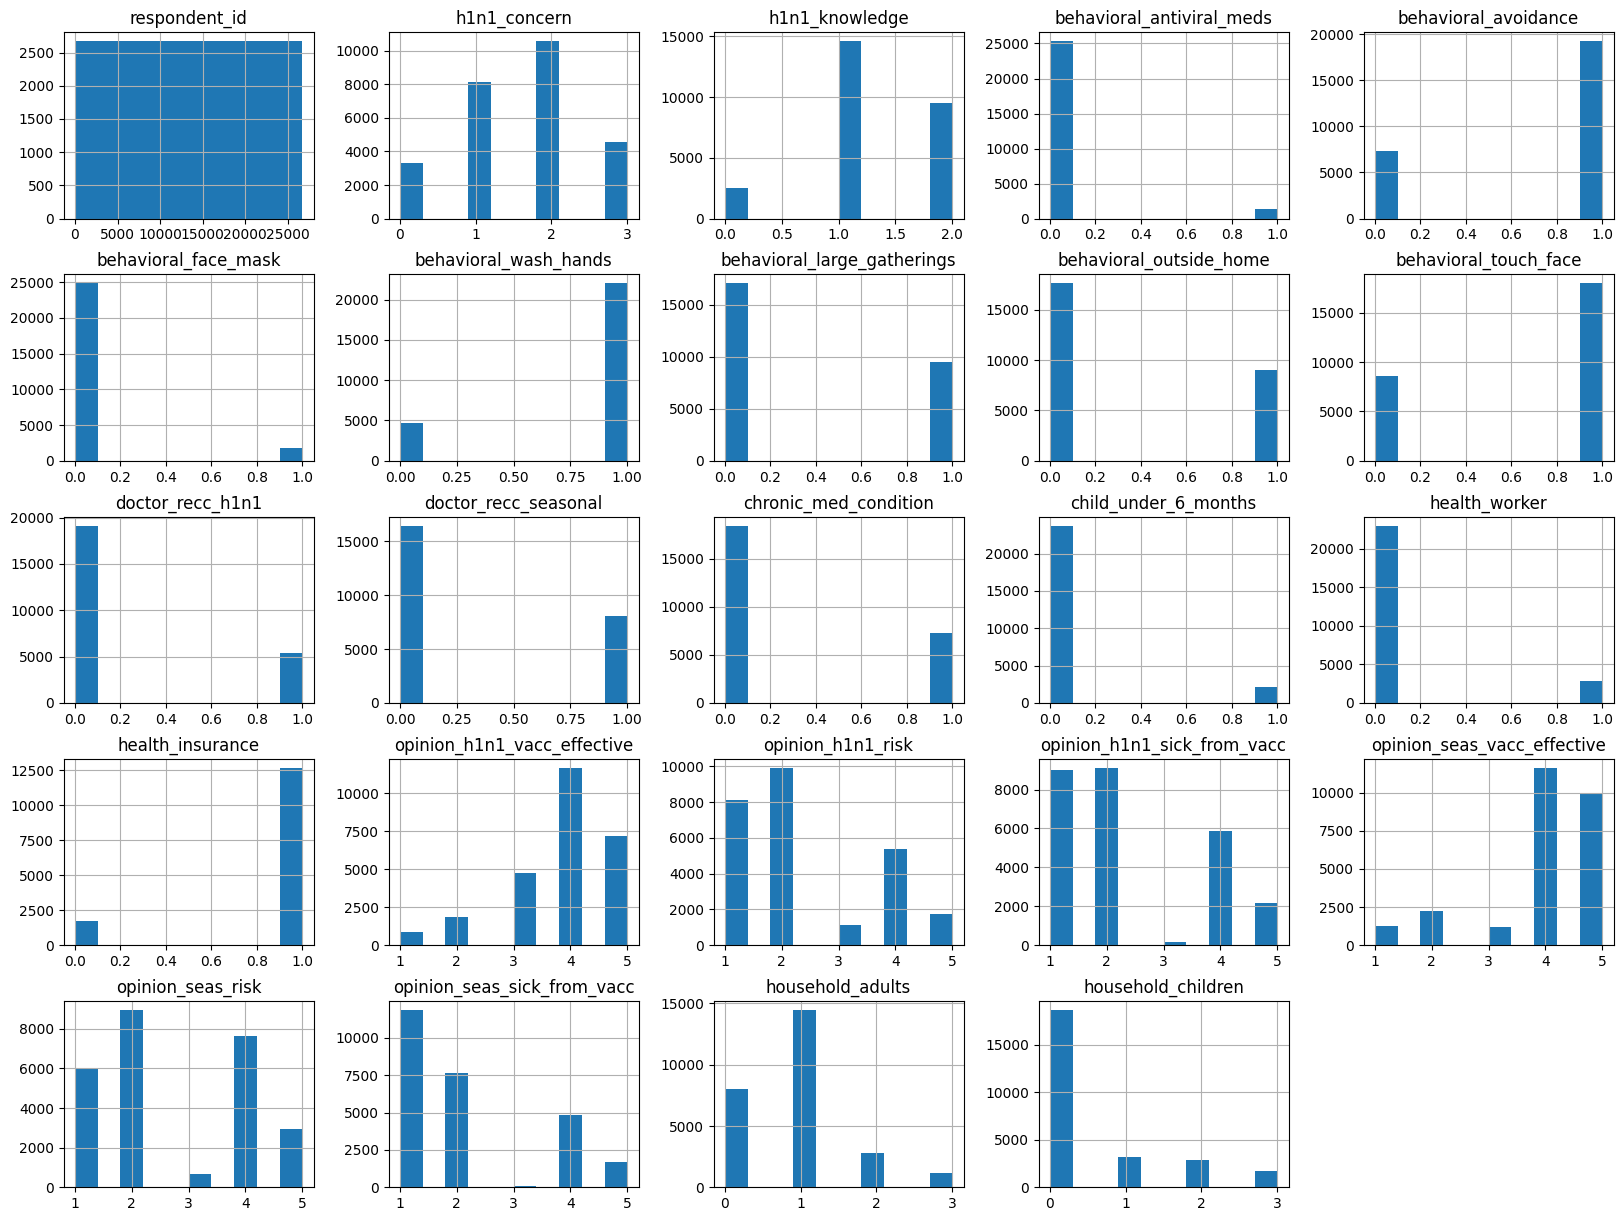

In [27]:
#using numeric columns lets plot some histograms
train_data.hist(bins=10, figsize=(20,15))
plt.show()

### predictions for correlations between the numerical features and targets
1. health worker should be be taking both the vaccine
2. most of them respondents have health insurance -> does having health insurance correlate to getting teh vaccine, would the health insurance cover the cost of the vaccine? if so, why wouldnt people take it?
3. if you are concern for h1n1 and seasonal flu are greater than 1, and your knowledge for the same are greater than 1, you would be more likely to get the vaccine.
4. if the doctor recommends the vaccine, one would be more likely to get it right?
5. only a small % of respondents are taking anti viral medicines, meaning that most of the respondents might not be aware of infections and would likely not get the h1n1 and flu vaccine.
6. if you are of the opinion that h1n1 and seas vaccine is effective with a score greater than 3, you would be more likely to take it.
7. if you of the opinion that h1n1 and seas vaccine is harmul/you could get sick and assigned the risk score and sick score in between 3 and 5, then you are more likely not to get the vaccine.


['age_group',
 'education',
 'race',
 'sex',
 'income_poverty',
 'marital_status',
 'rent_or_own',
 'employment_status',
 'hhs_geo_region',
 'census_msa',
 'employment_industry',
 'employment_occupation']

In [36]:
# combining the features_df to train_data
features_df.set_index('respondent_id')
train_data.set_index('respondent_id')
df_train = pd.merge(train_data, features_df, on='respondent_id', how='inner')
df_train.columns

Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation', 'h1n1_vaccine', 'seasonal_vaccine'],
      dtype='object')

In [39]:
# lets see pearson's coefficient to identy highly correlevant features to the target variable
corr_matrix = df_train.corr()

/var/folders/ml/z95wtw656_qcnkv6l6pr_1pm0000gn/T/ipykernel_16021/1055920771.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_train.corr()


In [40]:
corr_matrix["h1n1_vaccine"].sort_values(ascending=False)

h1n1_vaccine                   1.000000
doctor_recc_h1n1               0.393890
seasonal_vaccine               0.377143
opinion_h1n1_risk              0.323265
opinion_h1n1_vacc_effective    0.269347
opinion_seas_risk              0.258571
doctor_recc_seasonal           0.209864
opinion_seas_vacc_effective    0.179272
health_worker                  0.169768
h1n1_concern                   0.121929
health_insurance               0.121170
h1n1_knowledge                 0.117951
chronic_med_condition          0.095207
opinion_h1n1_sick_from_vacc    0.075091
behavioral_wash_hands          0.074712
behavioral_touch_face          0.071648
behavioral_face_mask           0.070498
child_under_6_months           0.066962
behavioral_avoidance           0.047690
behavioral_antiviral_meds      0.040608
behavioral_outside_home        0.021768
behavioral_large_gatherings    0.017822
opinion_seas_sick_from_vacc    0.008360
household_adults               0.007545
respondent_id                 -0.003280


In [41]:
corr_matrix['seasonal_vaccine'].sort_values(ascending=False)

seasonal_vaccine               1.000000
opinion_seas_risk              0.390106
h1n1_vaccine                   0.377143
doctor_recc_seasonal           0.369190
opinion_seas_vacc_effective    0.361875
opinion_h1n1_risk              0.216625
opinion_h1n1_vacc_effective    0.205072
health_insurance               0.200858
doctor_recc_h1n1               0.198607
chronic_med_condition          0.170174
h1n1_concern                   0.154828
health_worker                  0.127311
behavioral_touch_face          0.120228
h1n1_knowledge                 0.120152
behavioral_wash_hands          0.112414
behavioral_avoidance           0.076395
behavioral_large_gatherings    0.064025
behavioral_outside_home        0.053509
behavioral_face_mask           0.050083
opinion_h1n1_sick_from_vacc    0.027404
child_under_6_months           0.012097
behavioral_antiviral_meds      0.006277
respondent_id                 -0.004652
opinion_seas_sick_from_vacc   -0.061510
household_adults              -0.064840


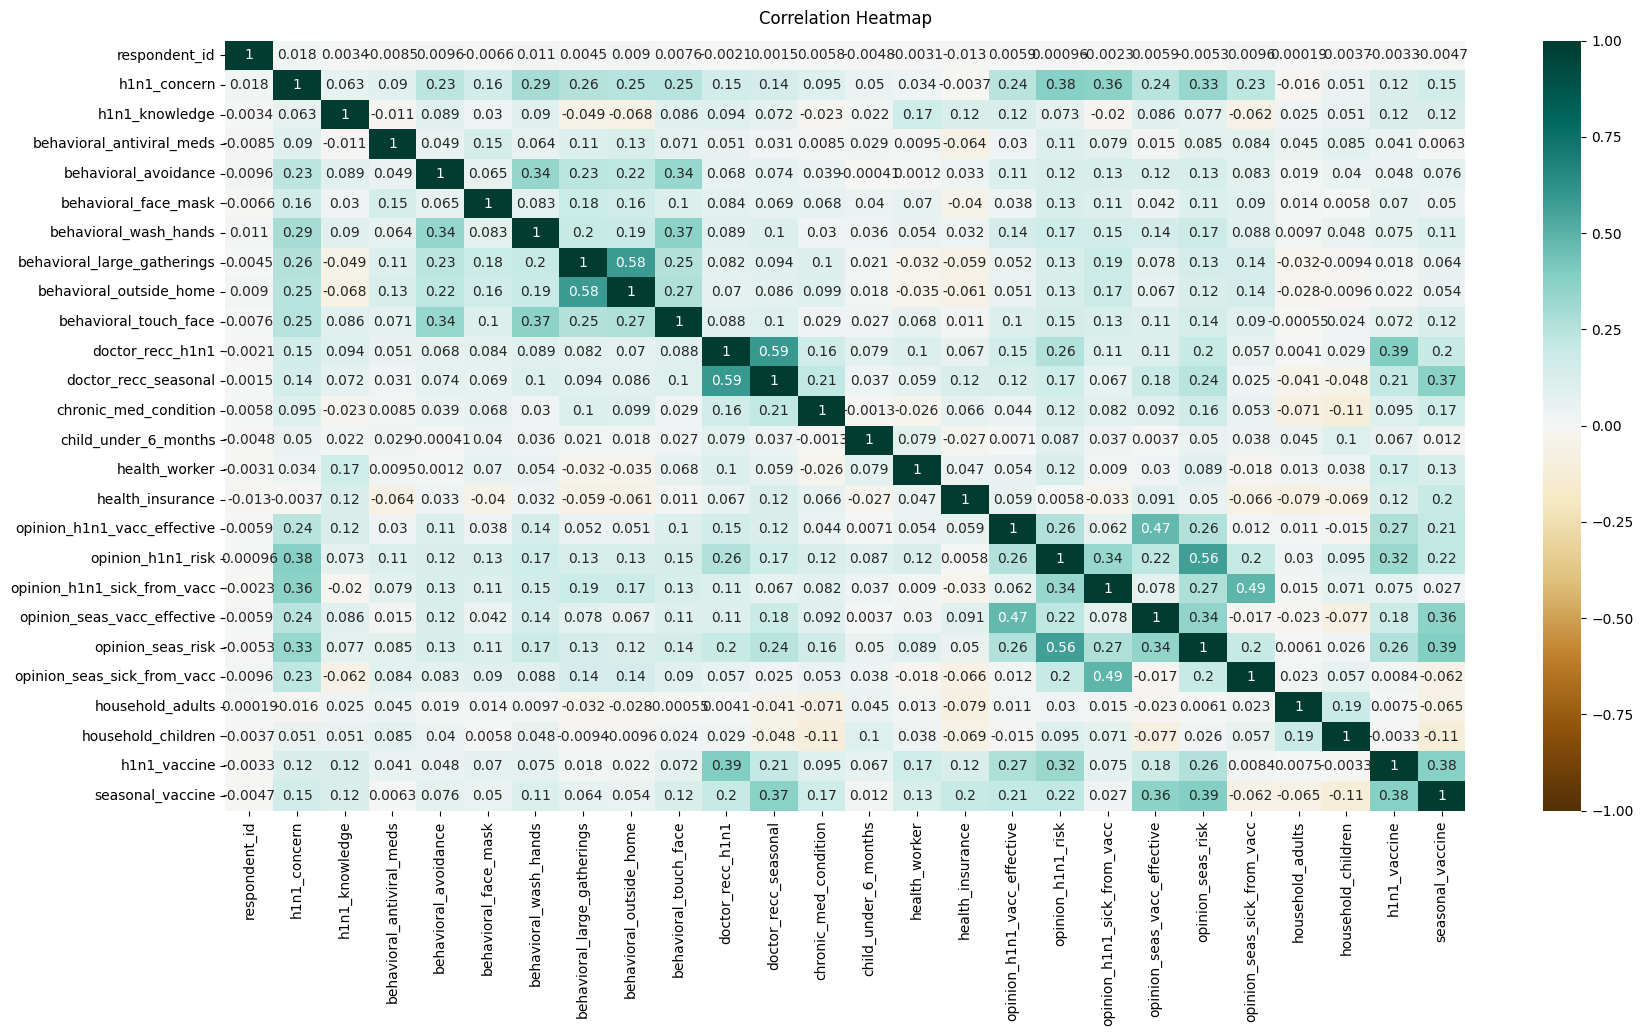

In [55]:
## correlation heatmap?
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Sample data
# data = {
#     'had_breakfast': [1, 0, 1, 0, 1],
#     'woke_up_before_8': [1, 0, 1, 0, 1],
#     'went_to_sleep_early': [0, 1, 1, 0, 1],
#     'hours_between_last_phone_usage_and_sleep_time': [3, 2, 1, 2, 3]
# }

# # Create DataFrame
# df = pd.DataFrame(data)

# # Calculate the correlation matrix
# corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(20, 10))
heatmap = sns.heatmap(corr_matrix, annot=True, cmap='BrBG', vmin=-1, vmax=1)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
# plt.title('Correlation Matrix Heatmap')
plt.show()


/var/folders/ml/z95wtw656_qcnkv6l6pr_1pm0000gn/T/ipykernel_16021/392834515.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_h1n1 = df_train.corr()[['h1n1_vaccine']].sort_values(by='h1n1_vaccine', ascending=False)
/var/folders/ml/z95wtw656_qcnkv6l6pr_1pm0000gn/T/ipykernel_16021/392834515.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_seas = df_train.corr()[['seasonal_vaccine']].sort_values(by='seasonal_vaccine', ascending=False)


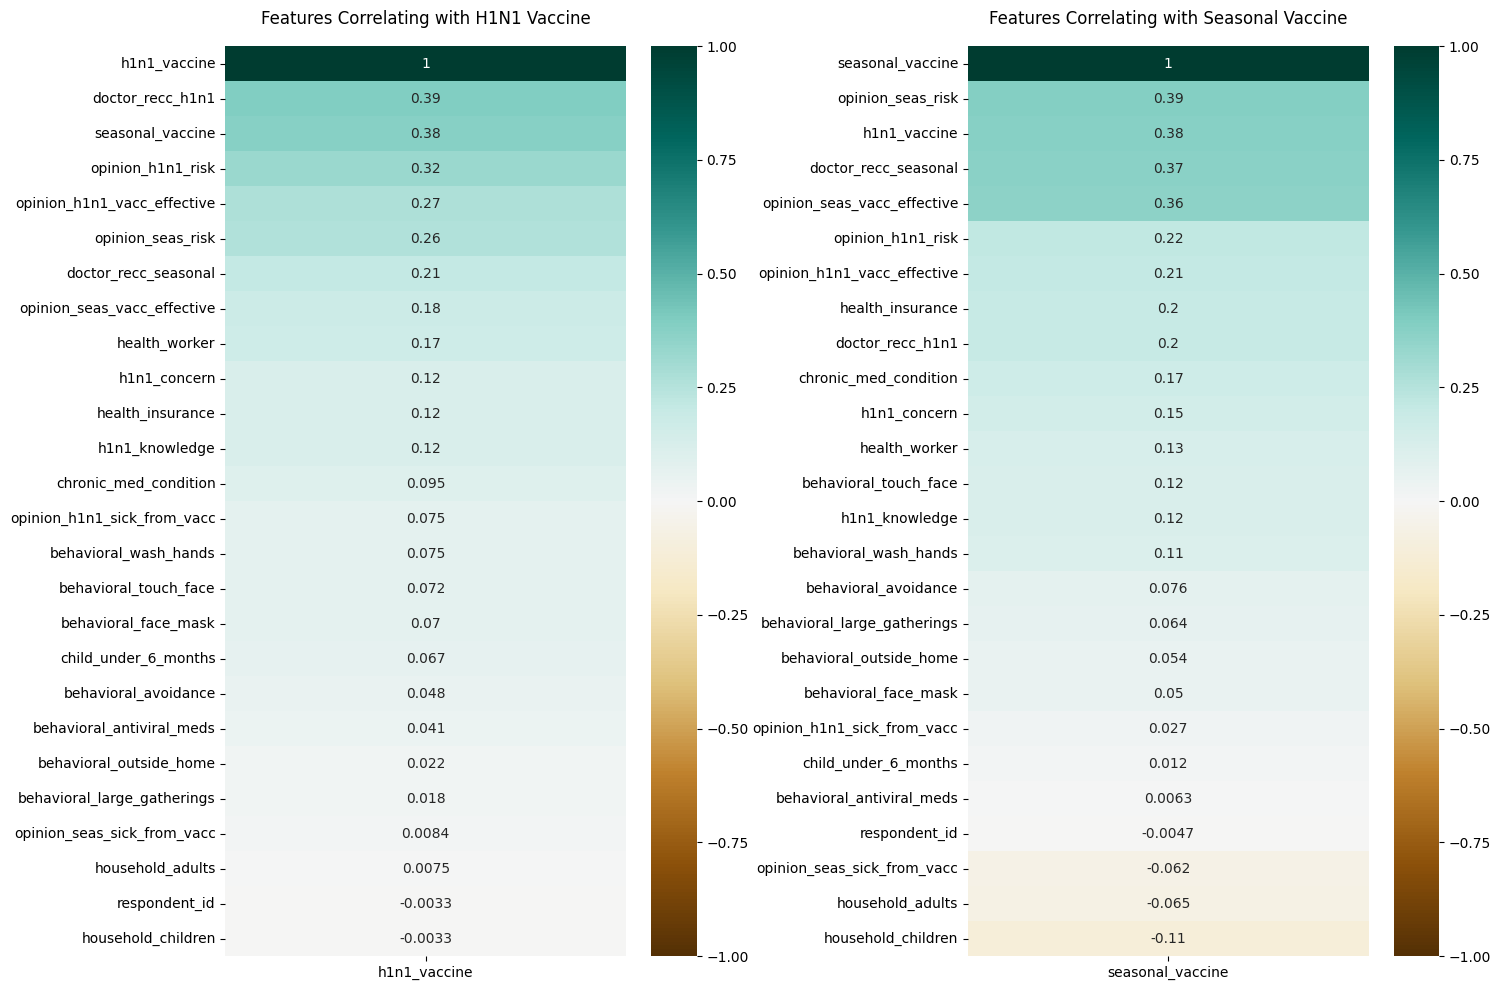

In [76]:
corr_h1n1 = df_train.corr()[['h1n1_vaccine']].sort_values(by='h1n1_vaccine', ascending=False)
corr_seas = df_train.corr()[['seasonal_vaccine']].sort_values(by='seasonal_vaccine', ascending=False)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))

# Plot heatmaps
sns.heatmap(corr_h1n1, vmin=-1, vmax=1, annot=True, cmap='BrBG', ax=ax1)
ax1.set_title('Features Correlating with H1N1 Vaccine', fontdict={'fontsize':12}, pad=16)

sns.heatmap(corr_seas, vmin=-1, vmax=1, annot=True, cmap='BrBG', ax=ax2)
ax2.set_title('Features Correlating with Seasonal Vaccine', fontdict={'fontsize':12}, pad=16)

plt.tight_layout()
plt.show()

### what do we see here?
- the second correlation variable for the two target variables shows that, its likely that if the respondent has taken either of teh vaccines they would have taken the other vaccine too.
- doctor recc -> plays well for both the vaccines sitting at top 3 in the two heatmaps
- risk from h1n1 and seas also in the top 3

In [77]:
non_numeric_columns

['age_group',
 'education',
 'race',
 'sex',
 'income_poverty',
 'marital_status',
 'rent_or_own',
 'employment_status',
 'hhs_geo_region',
 'census_msa',
 'employment_industry',
 'employment_occupation']

In [81]:
df_train['employment_status'].value_counts()

Employed              13560
Not in Labor Force    10231
Unemployed             1453
Name: employment_status, dtype: int64

In [152]:
df_train['marital_status_binary'].value_counts() # can map them as rent -0 and own as 1

1.0    13555
0.0    11744
Name: marital_status_binary, dtype: int64

In [96]:
df_train['sex_binary'] = df_train['sex'].map({'Female': 1, 'Male': 0})
df_train['sex_binary'].value_counts()

1    15858
0    10849
Name: sex_binary, dtype: int64

In [97]:
df_train.columns

Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation', 'h1n1_vaccine', 'seasonal_vaccine',
       'rent_or_own_binary', 'marital_status_binary', 'income_poverty_num',
       'sex_binary'],
      dt

In [174]:
## encoding some more non numerical features
age_edu_race_df = pd.get_dummies(df_train, columns=['age_group', 'education', 'race', 'employment_status'], drop_first=True)
age_edu_race_df.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,age_group_55 - 64 Years,age_group_65+ Years,education_< 12 Years,education_College Graduate,education_Some College,race_Hispanic,race_Other or Multiple,race_White,employment_status_Not in Labor Force,employment_status_Unemployed
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1,0,1,0,0,0,0,1,1,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,0,0,0,0,0,0,0,1,0,0
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,1,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0,1,0,0,0,0,0,1,1,0
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,0,0,0,0,1,0,0,1,0,0


In [176]:
age_edu_race_df.dtypes

respondent_id                             int64
h1n1_concern                            float64
h1n1_knowledge                          float64
behavioral_antiviral_meds               float64
behavioral_avoidance                    float64
behavioral_face_mask                    float64
behavioral_wash_hands                   float64
behavioral_large_gatherings             float64
behavioral_outside_home                 float64
behavioral_touch_face                   float64
doctor_recc_h1n1                        float64
doctor_recc_seasonal                    float64
chronic_med_condition                   float64
child_under_6_months                    float64
health_worker                           float64
health_insurance                        float64
opinion_h1n1_vacc_effective             float64
opinion_h1n1_risk                       float64
opinion_h1n1_sick_from_vacc             float64
opinion_seas_vacc_effective             float64
opinion_seas_risk                       

In [177]:
df_train_2 = age_edu_race_df.drop(columns=['sex', 'income_poverty', 'marital_status', 'rent_or_own', 'hhs_geo_region', 'census_msa', 'employment_industry', 'employment_occupation'])

In [178]:
df_train_2.dtypes

respondent_id                             int64
h1n1_concern                            float64
h1n1_knowledge                          float64
behavioral_antiviral_meds               float64
behavioral_avoidance                    float64
behavioral_face_mask                    float64
behavioral_wash_hands                   float64
behavioral_large_gatherings             float64
behavioral_outside_home                 float64
behavioral_touch_face                   float64
doctor_recc_h1n1                        float64
doctor_recc_seasonal                    float64
chronic_med_condition                   float64
child_under_6_months                    float64
health_worker                           float64
health_insurance                        float64
opinion_h1n1_vacc_effective             float64
opinion_h1n1_risk                       float64
opinion_h1n1_sick_from_vacc             float64
opinion_seas_vacc_effective             float64
opinion_seas_risk                       

In [179]:
## lets see if there are any empty or null values?
df_train_2.isnull().sum()

respondent_id                               0
h1n1_concern                               92
h1n1_knowledge                            116
behavioral_antiviral_meds                  71
behavioral_avoidance                      208
behavioral_face_mask                       19
behavioral_wash_hands                      42
behavioral_large_gatherings                87
behavioral_outside_home                    82
behavioral_touch_face                     128
doctor_recc_h1n1                         2160
doctor_recc_seasonal                     2160
chronic_med_condition                     971
child_under_6_months                      820
health_worker                             804
health_insurance                        12274
opinion_h1n1_vacc_effective               391
opinion_h1n1_risk                         388
opinion_h1n1_sick_from_vacc               395
opinion_seas_vacc_effective               462
opinion_seas_risk                         514
opinion_seas_sick_from_vacc       

In [102]:
imputer = SimpleImputer(strategy="median")
df_train_num = df_train.drop(non_numeric_columns, axis=1)
print(df_train_num.columns)
imputer.fit(df_train_num)

Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'household_adults',
       'household_children', 'h1n1_vaccine', 'seasonal_vaccine',
       'rent_or_own_binary', 'marital_status_binary', 'income_poverty_num',
       'sex_binary'],
      dtype='object')


SimpleImputer(strategy='median')

In [106]:
imputer.statistics_ == df_train_num.median().values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [109]:
simple_np_array = imputer.transform(df_train_num)
train_df = pd.DataFrame(simple_np_array, columns=df_train_num.columns)
train_df.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children,h1n1_vaccine,seasonal_vaccine,rent_or_own_binary,marital_status_binary,income_poverty_num,sex_binary
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1.0,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,2.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0
3,3.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,4.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,4.0,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,1.0,4.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0


In [111]:
train_df.isnull().sum()

respondent_id                  0
h1n1_concern                   0
h1n1_knowledge                 0
behavioral_antiviral_meds      0
behavioral_avoidance           0
behavioral_face_mask           0
behavioral_wash_hands          0
behavioral_large_gatherings    0
behavioral_outside_home        0
behavioral_touch_face          0
doctor_recc_h1n1               0
doctor_recc_seasonal           0
chronic_med_condition          0
child_under_6_months           0
health_worker                  0
health_insurance               0
opinion_h1n1_vacc_effective    0
opinion_h1n1_risk              0
opinion_h1n1_sick_from_vacc    0
opinion_seas_vacc_effective    0
opinion_seas_risk              0
opinion_seas_sick_from_vacc    0
household_adults               0
household_children             0
h1n1_vaccine                   0
seasonal_vaccine               0
rent_or_own_binary             0
marital_status_binary          0
income_poverty_num             0
sex_binary                     0
dtype: int

### Trying some other methods of imputation/filling null values in the dataset
- K nearest neighbours to fill values
- Mean/Mode imputation
- Multiple Imputation methods
- Deleting the values (don't cause keeping the values is much better than deleting it)

In [112]:
train_df.dtypes

respondent_id                  float64
h1n1_concern                   float64
h1n1_knowledge                 float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_worker                  float64
health_insurance               float64
opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_h1n1_sick_from_vacc    float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
household_adults               float64
household_children             float64
h1n1_vaccine                   float64
seasonal_vaccine         

In [180]:
## splitting the train and test dataset
train_set, val_set = train_test_split(df_train_2, test_size=0.33, random_state=42, shuffle=True)

In [181]:
print(train_set.shape, val_set.shape)
print(train_set.columns)

(17893, 42) (8814, 42)
Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'household_adults',
       'household_children', 'h1n1_vaccine', 'seasonal_vaccine',
       'rent_or_own_binary', 'marital_status_binary', 'income_poverty_num',
       'sex_binary', 'age_group_35 - 44 Years', 'age_group_45 - 54 Years',
       'age_group_55 - 64 Years', 'age_group_65+ Years',
       'education_< 12 Years', 'education_College Graduate',
       'education_Some Colle

In [182]:
target_columns = ['h1n1_vaccine', 'seasonal_vaccine']
x_train = train_set.drop(columns=target_columns)
x_val = val_set.drop(columns=target_columns)
y_train = train_set[target_columns]
y_val = val_set[target_columns]

In [183]:
numeric_cols = x_train.columns

In [184]:
# scaling using z-score normalisation
numeric_preprocessing_steps = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('simple_imputer', SimpleImputer(strategy='median')),
])

# create the preprocessor stage of final pipeline
# each entry in the transformer list is a tuple of
# (name you choose, sklearn transformer, list of columns)
preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", numeric_preprocessing_steps, numeric_cols)
    ],
    remainder = "drop"
)

In [185]:
estimators = MultiOutputClassifier(
    estimator=LogisticRegression(penalty="l2", C=1)
)

In [186]:
full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("estimators", estimators),
])

In [187]:
full_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler()),
                                                                  ('simple_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_lar...
       'age_group_45 - 54 Years', 'age_group_55 - 64 Years',
       'age_group_65+ Years', 'education_< 12 Years',
       'education_College Graduate', 'education_Some College', 'race_Hispanic',
       'race_Other or Multiple', 'race_White',
       'employment_status_Not in Labor Force', 'employment_status_Unemployed'],
      dtype='object'))])),
                ('estimators',
                 MultiOutputClassifier(estimator=LogisticRegression(C=1)))])

In [188]:
%%time
full_pipeline.fit(x_train, y_train)
preds = full_pipeline.predict_proba(x_val)
preds

CPU times: user 1.09 s, sys: 85.2 ms, total: 1.17 s
Wall time: 316 ms


[array([[0.9191409 , 0.0808591 ],
        [0.93546284, 0.06453716],
        [0.9443491 , 0.0556509 ],
        ...,
        [0.98908357, 0.01091643],
        [0.81000961, 0.18999039],
        [0.92383874, 0.07616126]]),
 array([[0.82661937, 0.17338063],
        [0.850444  , 0.149556  ],
        [0.18349328, 0.81650672],
        ...,
        [0.92621484, 0.07378516],
        [0.59105293, 0.40894707],
        [0.66849743, 0.33150257]])]

In [189]:
print(preds[0].shape, preds[1].shape)

(8814, 2) (8814, 2)


In [190]:
preds_df = pd.DataFrame({
    "h1n1_vaccine" : preds[0][:, 1],
    "seasonal_vaccine" : preds[1][:, 1],
},
    index = y_val.index
                       )
print("preds.shape:", preds_df.shape)
preds_df.head()

preds.shape: (8814, 2)


,h1n1_vaccine,seasonal_vaccine
15772,0.080859,0.173381
9407,0.064537,0.149556
16515,0.055651,0.816507
23353,0.156167,0.256829
10008,0.142840,0.275511


In [191]:
# plotting roc_auc curve
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0,1], [0,1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name} : AUC = {roc_auc_score(y_true, y_score):.4f}"
    )


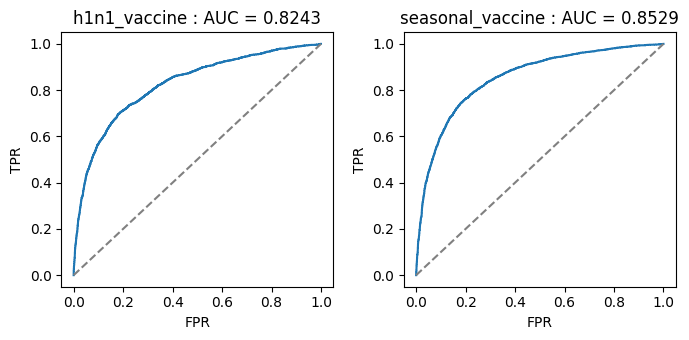

In [192]:
fig, ax = plt.subplots(1, 2, figsize=(7,3.5))
plot_roc(
    y_val['h1n1_vaccine'],
    preds_df['h1n1_vaccine'],
    'h1n1_vaccine',
    ax=ax[0]
)
plot_roc(
    y_val['seasonal_vaccine'],
    preds_df['seasonal_vaccine'],
    'seasonal_vaccine',
    ax=ax[1]
)
fig.tight_layout()

In [134]:
roc_auc_score(y_val, preds_df)

0.8315658982085821

In [193]:
roc_auc_score(y_val, preds_df)

0.8385903352769448

In [135]:
train_df.columns

Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'household_adults',
       'household_children', 'h1n1_vaccine', 'seasonal_vaccine',
       'rent_or_own_binary', 'marital_status_binary', 'income_poverty_num',
       'sex_binary'],
      dtype='object')

In [194]:
X_train, Y_train = df_train_2.drop(columns=target_columns, axis=1), df_train_2[target_columns]

In [197]:
Y_train.shape

(26707, 2)

In [198]:
%%time
full_pipeline.fit(X_train, Y_train)

CPU times: user 682 ms, sys: 19.3 ms, total: 701 ms
Wall time: 173 ms


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler()),
                                                                  ('simple_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_lar...
       'age_group_45 - 54 Years', 'age_group_55 - 64 Years',
       'age_group_65+ Years', 'education_< 12 Years',
       'education_College Graduate', 'education_Some College', 'race_Hispanic',
       'race_Other or Multiple', 'race_White',
       'employment_status_Not in Labor Force', 'employment_status_Unemployed'],
      dtype='object'))])),
                ('estimators',
                 MultiOutputClassifier(estimator=LogisticRegression(C=1)))])

In [199]:
test_data.set_index('respondent_id')
test_data.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,rent_or_own_binary,marital_status_binary,income_poverty_num,sex_binary
0,26707,2.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,mlyzmhmf,"MSA, Not Principle City",1.0,0.0,atmlpfrs,hfxkjkmi,0.0,0.0,1.0,1
1,26708,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,bhuqouqj,Non-MSA,3.0,0.0,atmlpfrs,xqwwgdyp,0.0,0.0,0.0,0
2,26709,2.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,lrircsnp,Non-MSA,1.0,0.0,nduyfdeo,pvmttkik,1.0,1.0,1.0,0
3,26710,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,lrircsnp,"MSA, Not Principle City",1.0,0.0,NaN,NaN,1.0,1.0,2.0,1
4,26711,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,lzgpxyit,Non-MSA,0.0,1.0,fcxhlnwr,mxkfnird,1.0,0.0,2.0,1


In [200]:
X_train.columns

Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'household_adults',
       'household_children', 'rent_or_own_binary', 'marital_status_binary',
       'income_poverty_num', 'sex_binary', 'age_group_35 - 44 Years',
       'age_group_45 - 54 Years', 'age_group_55 - 64 Years',
       'age_group_65+ Years', 'education_< 12 Years',
       'education_College Graduate', 'education_Some College', 'race_Hispanic',
       'race_Other or Multiple', 'race_White

In [202]:
test_data = pd.get_dummies(test_data, columns=['age_group', 'education', 'race', 'employment_status'], drop_first=True)
test_data.columns

Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'sex',
       'income_poverty', 'marital_status', 'rent_or_own', 'hhs_geo_region',
       'census_msa', 'household_adults', 'household_children',
       'employment_industry', 'employment_occupation', 'rent_or_own_binary',
       'marital_status_binary', 'income_poverty_num', 'sex_binary',
       'age_group_35 - 44 Years', 'age_group_45 - 54 Years',
       'age_group_55 - 64 Years', 'age_group_65+ Year

In [203]:
test_data = test_data.drop(columns=['sex', 'income_poverty', 'marital_status', 'rent_or_own', 'hhs_geo_region', 'census_msa', 'employment_industry', 'employment_occupation'])
test_data.dtypes

respondent_id                             int64
h1n1_concern                            float64
h1n1_knowledge                          float64
behavioral_antiviral_meds               float64
behavioral_avoidance                    float64
behavioral_face_mask                    float64
behavioral_wash_hands                   float64
behavioral_large_gatherings             float64
behavioral_outside_home                 float64
behavioral_touch_face                   float64
doctor_recc_h1n1                        float64
doctor_recc_seasonal                    float64
chronic_med_condition                   float64
child_under_6_months                    float64
health_worker                           float64
health_insurance                        float64
opinion_h1n1_vacc_effective             float64
opinion_h1n1_risk                       float64
opinion_h1n1_sick_from_vacc             float64
opinion_seas_vacc_effective             float64
opinion_seas_risk                       

In [206]:
X_train.shape

(26707, 40)

In [162]:
# test_data['income_poverty'].value_counts()

In [154]:
# test_data['rent_or_own_binary'] = test_data['rent_or_own'].map({'Own' : 1, 'Rent' : 0})
# test_data['marital_status_binary'] = test_data['marital_status'].map({'Married' : 1, 'Not Married' : 0})
# test_data['income_poverty_num'] = test_data['income_poverty'].map({'Below Poverty' : 0, '> $75,000' : 1, '<= $75,000, Above Poverty' : 2})
# test_data['sex_binary'] = test_data['sex'].map({'Female' : 1, 'Male':0})

In [205]:
test_data.shape

(26708, 40)

In [207]:
y_preds = full_pipeline.predict_proba(test_data)
print(y_preds[0].shape, y_preds[1].shape)

(26708, 2) (26708, 2)


In [208]:
y_preds_df = pd.DataFrame({
    "h1n1_vaccine" : y_preds[0][:, 1],
    "seasonal_vaccine" : y_preds[1][:, 1]
},
    index = test_data.index,
                         )
y_preds_df.head()

,h1n1_vaccine,seasonal_vaccine
0,0.078309,0.231507
1,0.046772,0.045275
2,0.456932,0.691121
3,0.510027,0.893906
4,0.196562,0.511246


In [209]:
np.testing.assert_array_equal(test_data.index.values, 
                              sample_submission.index.values)

# Save predictions to submission data frame
sample_submission["h1n1_vaccine"] = y_preds[0][:, 1]
sample_submission["seasonal_vaccine"] = y_preds[1][:, 1]

sample_submission.head()

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,26707,0.078309,0.231507
1,26708,0.046772,0.045275
2,26709,0.456932,0.691121
3,26710,0.510027,0.893906
4,26711,0.196562,0.511246


In [210]:
sample_submission.to_csv('submission2.csv', index=False)